In [209]:
"""
blocks.ipynb

Goal with this notebook is to analyze the impact of transitioning
from variable to fixed block times after the merge.

Towards the end of the notebook, there's a heavy focus on the impact of
this transition on the gas market.

TODO: Get data on block building process and whether portions of now fixed block time interval are more valuable.
"""

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import typing as tp

from ape import accounts, chain, Contract, networks
from scipy import stats

In [3]:
# SEE: https://gist.github.com/banteg/dcf6082ff7fc6ad51ce220146f29d9ff
networks.parse_network_choice('ethereum:mainnet:alchemy').__enter__()

<alchemy chain_id=1>

In [58]:
# PREP: look at the current block
current_block = chain.blocks[-1]
current_block

Block(num_transactions=201, hash=HexBytes('0x390f8608cff6667c959bd0a2747ba30df9da472e678e0b5292aa0c9da7432a73'), number=15754050, parent_hash=HexBytes('0x360820bb06cd1d5cd8094cf12eced95eefeea8a3d02c1b09f850e0d534603c08'), size=89395, timestamp=1665843335, gas_limit=30000000, gas_used=17248926, base_fee=13934640309, difficulty=0, total_difficulty=58750003716598352816469)

In [146]:
# some relevant numbers
start_block_number = 15338009 # ~1 month before merge
merge_block_number = 15537394
current_block_number = current_block.number

In [60]:
# PREP: get txs in current block
print('num txs in block:', len(current_block.transactions))

num txs in block: 201


In [65]:
# check out an EIP1559 tx in list of tx within this block
tx_dynamic_fee = current_block.transactions[0]
tx_dynamic_fee

<DynamicFeeTransaction chainId=1, to=0x56D5B9Aa337C0a57598E9d4004584805cf8271B8, from=0x0D957354C5fD457d689D7A0c84Cd55aA0670108B, gas=79419, nonce=117, value=0, data=b'0xa694fc3a0000000000000000000000000000000000000000000000000000000000000391', type=0x02, maxFeePerGas=350000000000, maxPriorityFeePerGas=100000000000, accessList=[]>

In [66]:
print('max fee:', tx_dynamic_fee.max_fee)
print('max priority fee:', tx_dynamic_fee.max_priority_fee)
print('gas limit:', tx_dynamic_fee.gas_limit)
print('signature:', tx.signature)

max fee: 350000000000
max priority fee: 100000000000
gas limit: 79419
signature: <TransactionSignature v=1 r=16e7fa6853b648ce10a876ca8e5f80648f11d1c1cf69ec3b3208f7a14a914a02 s=4ccfa30d76e8935bf259509162362a8bd31b0d9d90dca0e5f4d55d16e5325b8c>


In [292]:
# load from csv if already queried, else do the query and save in csv
def load_blocks(fp: str) -> pd.DataFrame:
    if os.path.exists(fp):
        return pd.read_csv(fp)
    else:
        qb = chain.blocks.query('*', start_block=start_block_number)
        qb.to_csv(fp, index=False)
        return qb

In [67]:
# get blocks over last 2 months (since mid Aug to mid October)
# %time query_blocks = chain.blocks.query('*', start_block=start_block_number)

CPU times: user 1h 23min 20s, sys: 4min 20s, total: 1h 27min 40s
Wall time: 15h 23s


In [69]:
# save to csv so don't have to query again
# query_blocks.to_csv('./data/blocks.csv', index=False)

In [75]:
%time qb = load_blocks('./data/blocks.csv')

CPU times: user 889 ms, sys: 73.1 ms, total: 962 ms
Wall time: 966 ms


In [81]:
qb

,num_transactions,hash,number,parent_hash,size,timestamp,gas_limit,gas_used,base_fee,difficulty,total_difficulty,dtimestamp
0,97,"b'\xf0\x82\x95\x1e@\xe4by\xfc,\x15\xd6\xb6xFw\...",15338009,b'm\xb0\x02|\xa9}\x84\xa3\xdd\xc1\x84\xb6\xe4\...,39308,1660456780,30000000,9954560,8122412901,12045723921070914,56321843715293942409414,NaN
1,305,b'\xdb\x91:\xfc8Qk\xc1c\x82\xe2\xdbA\xe9b#R\xe...,15338010,"b'\xf0\x82\x95\x1e@\xe4by\xfc,\x15\xd6\xb6xFw\...",99210,1660456787,30000000,22464133,7780903344,12051743061157721,56321855767037003567135,7.0
2,51,b'\xb0\x0c2\x7f$\xc0\xec$i\xbf\xd9\xcb\x13\x0c...,15338011,b'\xdb\x91:\xfc8Qk\xc1c\x82\xe2\xdbA\xe9b#R\xe...,13806,1660456811,30000000,3781159,8264884155,12045995859944613,56321867813032863511748,24.0
3,24,"b""0\xbc\xf0\xa6\x89\xf1w\x1d\x9d\x05\x1c\xc8\x...",15338012,b'\xb0\x0c2\x7f$\xc0\xec$i\xbf\xd9\xcb\x13\x0c...,7824,1660456814,29970705,1551283,7492197312,12057896966730061,56321879870929830241809,3.0
4,63,b'`/\xd0\xe0\x7fvc>\x94\xf2\xd1\xca\xbf\x11\x9...,15338013,"b""0\xbc\xf0\xa6\x89\xf1w\x1d\x9d\x05\x1c\xc8\x...",16003,1660456819,29941438,3174533,6652621642,12063922050686819,56321891934851880928628,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
416045,189,b'\xecP\xf7g\x08\xc2\x19\x12_\x0c\xd8X\x92\x9b...,15754054,b'\x12Y[\x91y.\xb8\xcf\xd7\xca\xb5\x81\x87\x82...,82178,1665843383,30000000,18028304,14001417244,0,58750003716598352816469,12.0
416046,253,b'n\xf2R{ \xa9t\xabUD\xbc\x8e\x04B\x87\xb3\t\x...,15754055,b'\xecP\xf7g\x08\xc2\x19\x12_\x0c\xd8X\x92\x9b...,159816,1665843395,30000000,29936690,14354755142,0,58750003716598352816469,12.0
416047,137,b'\xb7\x06\xba9s\x7f>p\xd1\xa3\x16\xb0)Y\n\xd4...,15754056,b'n\xf2R{ \xa9t\xabUD\xbc\x8e\x04B\x87\xb3\t\x...,71368,1665843407,30000000,14425421,16141526205,0,58750003716598352816469,12.0
416048,117,b'\x86\xd9n\xfb+\x9e\n\xbc\xb3\x99\x155@\xbb\x...,15754057,b'\xb7\x06\xba9s\x7f>p\xd1\xa3\x16\xb0)Y\n\xd4...,56671,1665843419,30000000,11198548,16064238022,0,58750003716598352816469,12.0


In [109]:
# difference the timestamps and get the timestamp in date format
qb['dtimestamp'] = qb['timestamp'].diff()  # block time for this current block to be added
qb['date'] = pd.to_datetime(qb['timestamp'], unit='s')

In [110]:
qb

,num_transactions,hash,number,parent_hash,size,timestamp,gas_limit,gas_used,base_fee,difficulty,total_difficulty,dtimestamp,date
0,97,"b'\xf0\x82\x95\x1e@\xe4by\xfc,\x15\xd6\xb6xFw\...",15338009,b'm\xb0\x02|\xa9}\x84\xa3\xdd\xc1\x84\xb6\xe4\...,39308,1660456780,30000000,9954560,8122412901,12045723921070914,56321843715293942409414,NaN,2022-08-14 05:59:40
1,305,b'\xdb\x91:\xfc8Qk\xc1c\x82\xe2\xdbA\xe9b#R\xe...,15338010,"b'\xf0\x82\x95\x1e@\xe4by\xfc,\x15\xd6\xb6xFw\...",99210,1660456787,30000000,22464133,7780903344,12051743061157721,56321855767037003567135,7.0,2022-08-14 05:59:47
2,51,b'\xb0\x0c2\x7f$\xc0\xec$i\xbf\xd9\xcb\x13\x0c...,15338011,b'\xdb\x91:\xfc8Qk\xc1c\x82\xe2\xdbA\xe9b#R\xe...,13806,1660456811,30000000,3781159,8264884155,12045995859944613,56321867813032863511748,24.0,2022-08-14 06:00:11
3,24,"b""0\xbc\xf0\xa6\x89\xf1w\x1d\x9d\x05\x1c\xc8\x...",15338012,b'\xb0\x0c2\x7f$\xc0\xec$i\xbf\xd9\xcb\x13\x0c...,7824,1660456814,29970705,1551283,7492197312,12057896966730061,56321879870929830241809,3.0,2022-08-14 06:00:14
4,63,b'`/\xd0\xe0\x7fvc>\x94\xf2\xd1\xca\xbf\x11\x9...,15338013,"b""0\xbc\xf0\xa6\x89\xf1w\x1d\x9d\x05\x1c\xc8\x...",16003,1660456819,29941438,3174533,6652621642,12063922050686819,56321891934851880928628,5.0,2022-08-14 06:00:19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
416045,189,b'\xecP\xf7g\x08\xc2\x19\x12_\x0c\xd8X\x92\x9b...,15754054,b'\x12Y[\x91y.\xb8\xcf\xd7\xca\xb5\x81\x87\x82...,82178,1665843383,30000000,18028304,14001417244,0,58750003716598352816469,12.0,2022-10-15 14:16:23
416046,253,b'n\xf2R{ \xa9t\xabUD\xbc\x8e\x04B\x87\xb3\t\x...,15754055,b'\xecP\xf7g\x08\xc2\x19\x12_\x0c\xd8X\x92\x9b...,159816,1665843395,30000000,29936690,14354755142,0,58750003716598352816469,12.0,2022-10-15 14:16:35
416047,137,b'\xb7\x06\xba9s\x7f>p\xd1\xa3\x16\xb0)Y\n\xd4...,15754056,b'n\xf2R{ \xa9t\xabUD\xbc\x8e\x04B\x87\xb3\t\x...,71368,1665843407,30000000,14425421,16141526205,0,58750003716598352816469,12.0,2022-10-15 14:16:47
416048,117,b'\x86\xd9n\xfb+\x9e\n\xbc\xb3\x99\x155@\xbb\x...,15754057,b'\xb7\x06\xba9s\x7f>p\xd1\xa3\x16\xb0)Y\n\xd4...,56671,1665843419,30000000,11198548,16064238022,0,58750003716598352816469,12.0,2022-10-15 14:16:59


<AxesSubplot: xlabel='number', ylabel='dtimestamp'>

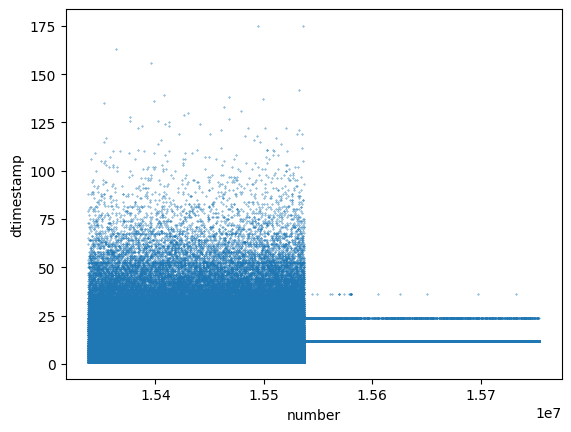

In [340]:
# plot block times over time
# TODO: why two bands after merge?
qb.plot(x='number', y='dtimestamp', kind='scatter', s=0.1)

<AxesSubplot: ylabel='Frequency'>

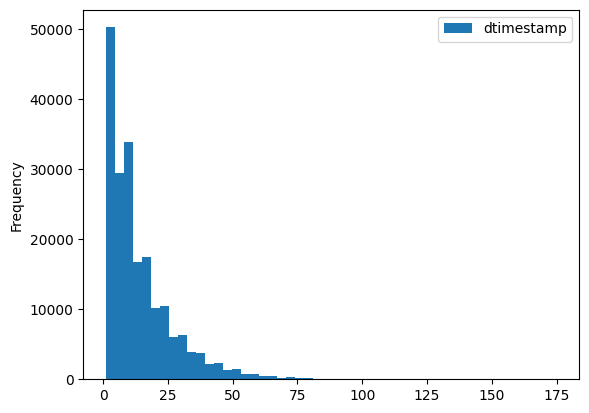

In [344]:
# plot distribution of block times before merge
qb[qb['number'] < merge_block_number].plot(y='dtimestamp', kind='hist', bins=50)

<AxesSubplot: ylabel='Frequency'>

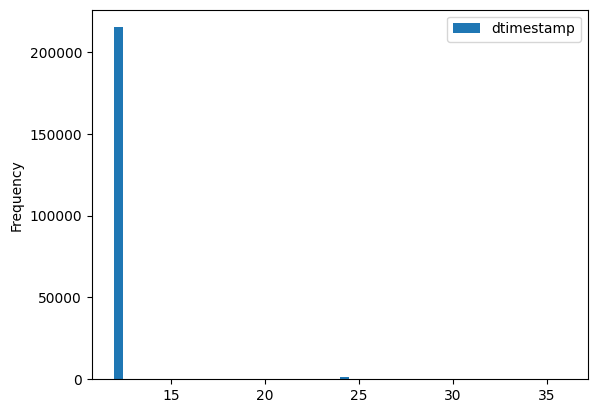

In [345]:
# plot distribution of block times after merge
# NOTE: some blocks come in at 24s
qb[qb['number'] >= merge_block_number].plot(y='dtimestamp', kind='hist', bins=50)

<AxesSubplot: xlabel='number', ylabel='dtimestamp'>

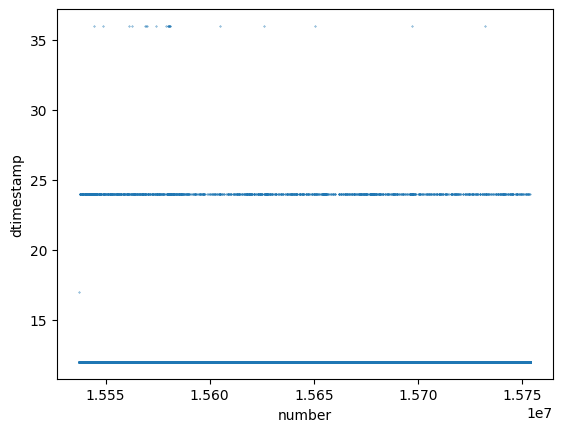

In [343]:
# scatter plot after merge
# NOTE: do have some blocks coming in at 2x fixed block length and others at weird block times
qb[qb['number'] >= merge_block_number].plot(x='number', y='dtimestamp', kind='scatter', s=0.1)

In [155]:
# how many come in at 24s? at 36s? (missed slots/blocks?)
#  ... ~ 0.7% of post merge blocks at 24s, ~ 0.0097% of post merge blocks at 36s
print('# blocks after merge:', qb[(qb['number'] >= merge_block_number)]['dtimestamp'].count())
print('# blocks after merge w block time == 24s:', qb[(qb['number'] >= merge_block_number) & (qb['dtimestamp'] == 24)]['dtimestamp'].count())
print('# blocks after merge w block time == 36s:', qb[(qb['number'] >= merge_block_number) & (qb['dtimestamp'] == 36)]['dtimestamp'].count())
print('fraction of blocks after merge w block time == 24s:', qb[(qb['number'] >= merge_block_number) & (qb['dtimestamp'] == 24)]['dtimestamp'].count() / qb[(qb['number'] >= merge_block_number)]['dtimestamp'].count())
print('fraction of blocks after merge w block time == 36s:', qb[(qb['number'] >= merge_block_number) & (qb['dtimestamp'] == 36)]['dtimestamp'].count() / qb[(qb['number'] >= merge_block_number)]['dtimestamp'].count())

# blocks after merge: 216665
# blocks after merge w block time == 24s: 1565
# blocks after merge w block time == 36s: 21
fraction of blocks after merge w block time == 24s: 0.007223132485634505
fraction of blocks after merge w block time == 36s: 9.692382249094224e-05


In [160]:
# look at the really weird block (not multiple of fixed block time == 12s)
#  ... first block of 17s block time happened at merge
qb[(qb['number'] >= merge_block_number) & (qb['dtimestamp'] % 12 != 0)]

,num_transactions,hash,number,parent_hash,size,timestamp,gas_limit,gas_used,base_fee,difficulty,total_difficulty,dtimestamp,date,gas_filled
199385,80,b'V\xa9\xbb\x03\x02\xdaD\xb8\xc0\xb3\xdfT\x07\...,15537394,b'U\xb1\x1b\x91\x83U\xb1\xef\x9c]\xb8\x100.\xb...,18559,1663224179,30000000,29983006,48811794595,0,58750003716598352816469,17.0,2022-09-15 06:42:59,0.999434


In [295]:
# TODO: what's causing these missed slots/blocks?

In [ ]:
# TODO: Impact of shorter and consistent block times
# TODO:  a. [x] Going from ~13s to 12s should theoretically provide an ~8% increase in blocks per day
# TODO:  b. [ ] Affect on fee-markets, on chain activity, etc

<AxesSubplot: xlabel='date'>

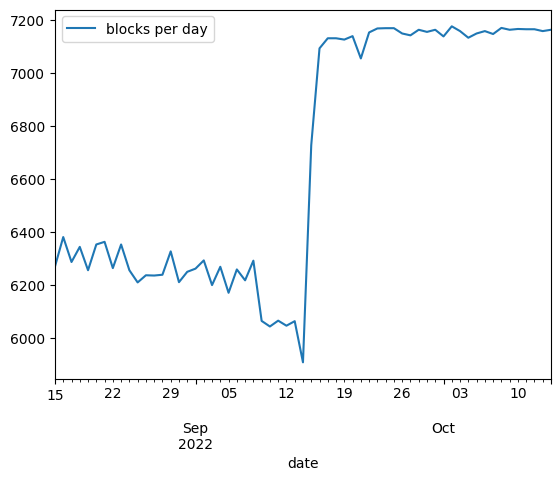

In [381]:
# look at rate of block production per day
#  ... seems pretty steady increase terms of # blocks produced per day
#  ... Seeing ~12.5% increase in blocks per day, which is significantly larger than expected ~8% increase. Why?
#  ... Q: is increase of ~12.5% vs expected 8% due to *fewer* dropped blocks post-merge?
# NOTE: remove ends since query starts/ends between days
qb_block_count = qb.set_index('date').resample('1D').aggregate({'number': 'count'})[1:-1]
qb_block_count.plot(y='number', label='blocks per day')

In [395]:
merge_date = qb[qb['number'] == merge_block_number]['date'].iloc[0]
merge_date

Timestamp('2022-09-15 06:42:59')

<AxesSubplot: xlabel='date'>

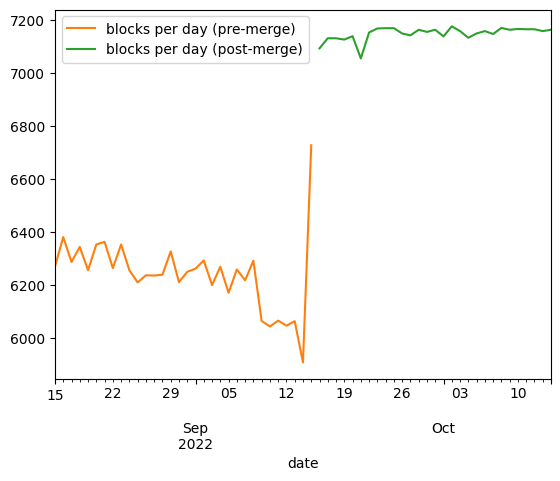

In [397]:
# plot again but with different colors pre v.s. post merge to show difference
ax = qb_block_count[qb_block_count.index < merge_date].plot(y='number', color='C1', label='blocks per day (pre-merge)')
qb_block_count[qb_block_count.index >= merge_date].plot(y='number', color='C2', ax=ax, label='blocks per day (post-merge)')

In [ ]:
# TODO: b. => look at base fee over time

In [ ]:
# TODO: Pre/post-merge execution layer health and metrics:
# TODO:  a. [x] Changes in gas limit?
# TODO:  b. [x] Empty vs full blocks pre vs post merge?
# TODO:  c. [ ] Utilization of PREVRANDAO

<AxesSubplot: xlabel='number', ylabel='gas_limit'>

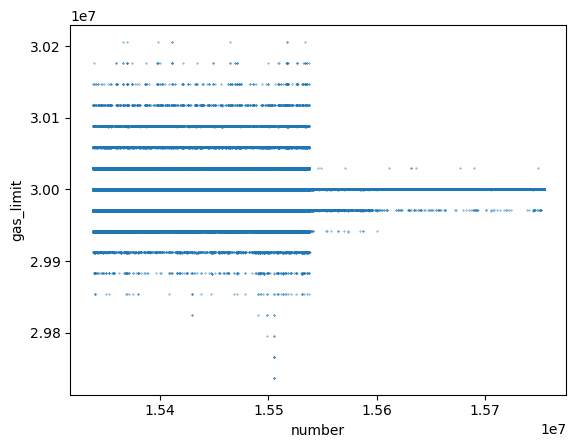

In [346]:
# check out some gas related quantites pre/post merge
# look at the gas limit post merge ...
#  ... looks like less variance in gas limit post merge
qb.plot(x='number', y='gas_limit', kind='scatter', s=0.1)

<AxesSubplot: ylabel='Frequency'>

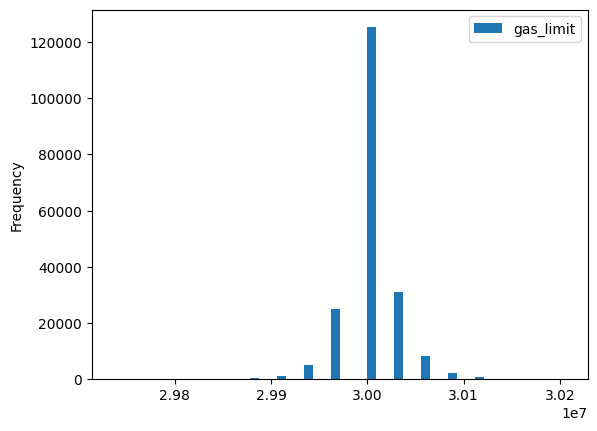

In [347]:
# to be sure plot histograms pre and post merge
qb[qb['number'] < merge_block_number].plot(y='gas_limit', kind='hist', bins=50)

<AxesSubplot: ylabel='Frequency'>

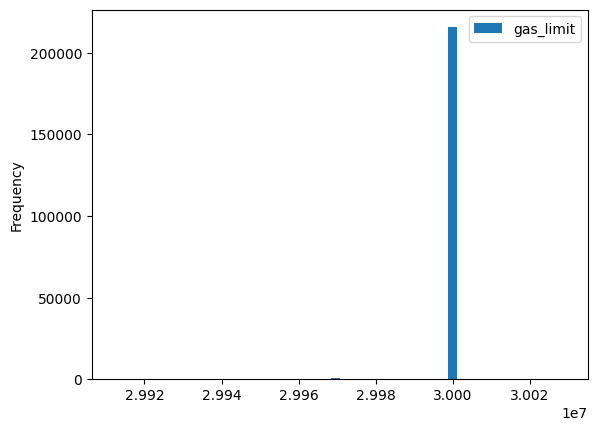

In [348]:
# gas limit post merge
#  ... really concentrated around 30,000,000 gas with few deviations
qb[qb['number'] >= merge_block_number].plot(y='gas_limit', kind='hist', bins=50)

In [158]:
# calc fraction of gas limit used per block
qb['gas_filled'] = qb['gas_used'] / qb['gas_limit']

<AxesSubplot: ylabel='Frequency'>

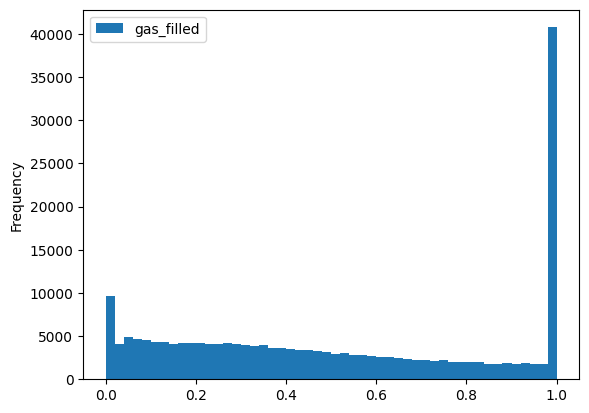

In [256]:
# plot distribution of gas limit utilization
#  ... pre merge
qb[qb['number'] < merge_block_number].plot(y='gas_filled', kind='hist', bins=50)

<AxesSubplot: ylabel='Frequency'>

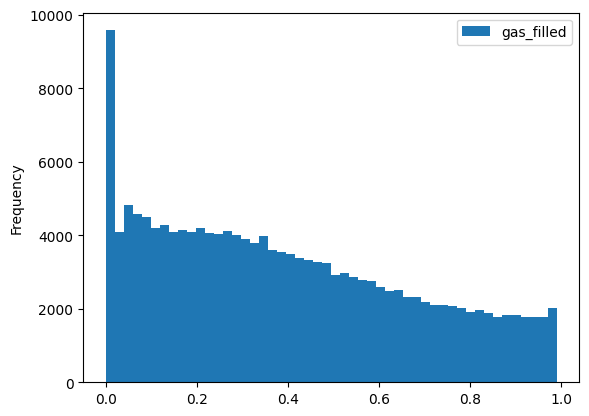

In [257]:
# plot distribution of gas limit utilization
#  ... pre merge; ignore around 1 for later comparison
#  ... close to uniform
qb[(qb['number'] < merge_block_number) & (qb['gas_filled'] < 0.99)].plot(y='gas_filled', kind='hist', bins=50)

<AxesSubplot: ylabel='Frequency'>

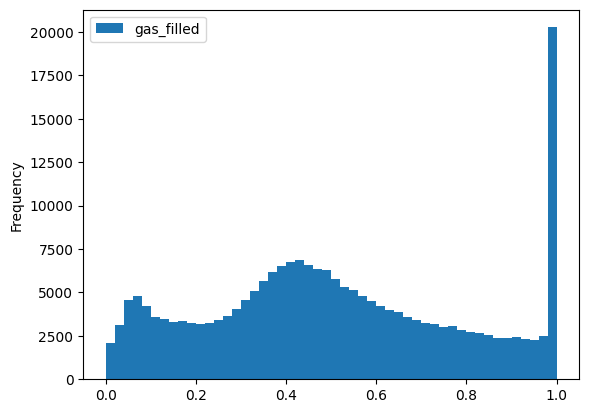

In [258]:
# plot distribution of gas limit utilization
#  ... post merge; woah, that's pretty cool and weird (?)
#  ... Q: why does % of gas filled post merge peak around 0.5 (sorta bell curved; ignoring extreme of filled completely == 1)
qb[qb['number'] >= merge_block_number].plot(y='gas_filled', kind='hist', bins=50)

<AxesSubplot: ylabel='Frequency'>

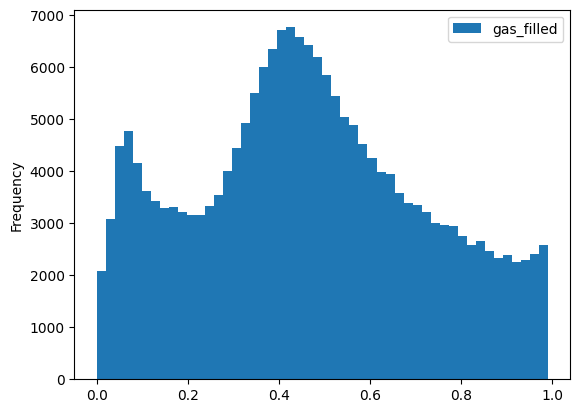

In [291]:
#  ... Q: why does % of gas filled post merge seem to be sorta normally distributed around 0.5 (excluding ~1 utilization numbers)
#  ... Q: is this expected? interesting ...
#  ... Q: is this randomness from variable block times moving to randomness in gas utilization?
#  ... Q: why would this peak around 50% gas filled?
qb[(qb['number'] >= merge_block_number) & (qb['gas_filled'] < 0.99)].plot(y='gas_filled', kind='hist', bins=50)

In [286]:
# fit histograms and plot
size = qb[(qb['number'] >= merge_block_number) & (qb['gas_filled'] < 0.99)]['gas_filled'].count()
x = np.arange(size) / size
dist_names = ['norm', 'cauchy', 'logistic', 'gamma', 't', 'weibull_max']

params (norm): (0.4632308304107377, 0.25221748645625663)
params (cauchy): (0.4499148417328136, 0.16066214926259606)
params (logistic): (0.4587847073850225, 0.14859912074030002)
params (gamma): (69.22423077980568, -1.6318056234028107, 0.030245530247041144)
params (t): (13731416.291804418, 0.46320600260689526, 0.2522003520688402)
params (weibull_max): (3.7230975355269758, 1.2861137111394103, 0.9134012737305327)


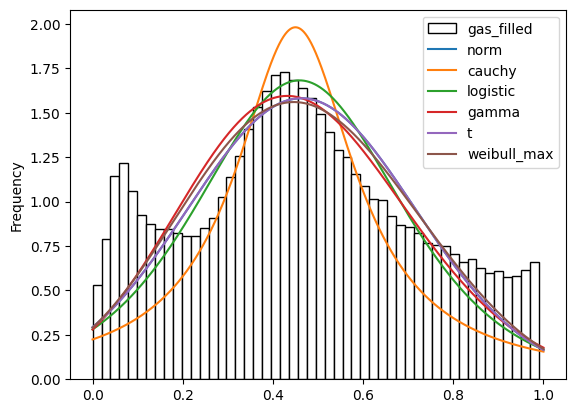

In [294]:
# Plot multiple dist fits over gas filled histogram
# SEE: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

# NOTE: hard to tell, need more data.
# NOTE: still, currently looks approx symmetric around ~ 45-46% utilization, if this is anything interesting
ax = qb[(qb['number'] >= merge_block_number) & (qb['gas_filled'] < 0.99)].plot(y='gas_filled', kind='hist', bins=50, color='w', edgecolor='black', density=True)
for dist_name in dist_names:
    params = getattr(stats, dist_name).fit(qb[(qb['number'] >= merge_block_number) & (qb['gas_filled'] < 0.99)]['gas_filled'])
    print(f'params ({dist_name}):', params)
    arg = params[:-2]
    pdf = getattr(stats, dist_name).pdf(x, *arg, loc=params[-2], scale=params[-1])
    df_pdf = pd.DataFrame(data={dist_name: pdf}, index=x)
    df_pdf.plot(ax=ax)

<AxesSubplot: xlabel='number', ylabel='gas_filled'>

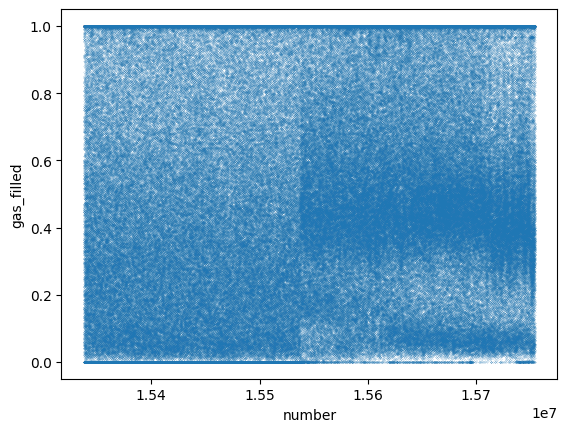

In [339]:
# Plot gas filled over time to get a sense historically (and around merge)
qb.plot(x='number', y='gas_filled', kind='scatter', s=0.01)

<AxesSubplot: xlabel='number', ylabel='gas_filled'>

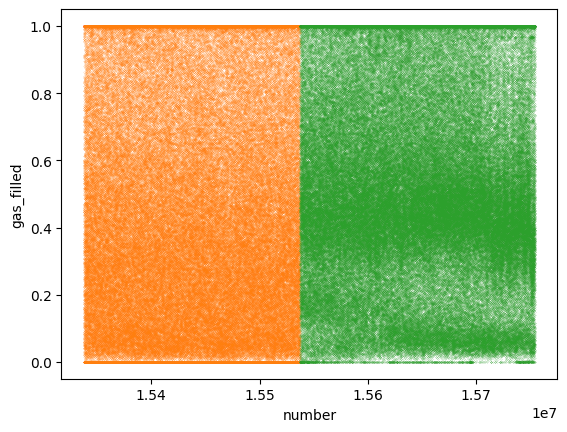

In [338]:
# Plot gas filled over time to get a sense historically (and around merge);
# Change colors pre/post merge to make it easier to compare.
#  ... does seem to also suggest some level of concentration around ~ 0.5 utilization post-merge
#       but is there a good reason to expect this?
#  ... unclear if will be significant once more data comes in
ax = qb[(qb['number'] < merge_block_number)].plot(x='number', y='gas_filled', kind='scatter', s=0.01, color='C1')
qb[(qb['number'] >= merge_block_number)].plot(x='number', y='gas_filled', kind='scatter', s=0.01, color='C2', ax=ax)

In [ ]:
# TODO: get numbers on frequency of empty blocks and uniform distr level
#
# Looks like ...
#  ... pre-merge: miners were filling empty blocks pretty frequently, but close to uniform distribution
#  ...            of gas used when ignoring utilization numbers of ~ 1
# 
#  ... post-merge: in POS, seeing gas used look more normally distributed around 50% utilization
#  ...             when ignoring utilization numbers of ~ 1
#
# Q: any relevance to idea might be a transformation from Poisson randomness in block times in POW to "Gaussian" randomness in gas utilization for POS?

In [281]:
# TODO: get txs in each block over last 2 months (since mid Aug to mid October)